# Assignment 11

In this assignment we'll examine a data set called `failure_counts.csv`. 

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. Your work will be manually graded by our TA. 

Protip: if you write your `.stan` file generally enough, it will work with most of the models below, and you won't need to keep recompiling the model object!


In [1]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

## Description of The Data Set

We are interested in estimating the probability of failure of a new type of rocket. We have little to no data on this particular type of rocket (it's new, and rocket launches are expensive). However, the data we *do* have is on *related* rockets. 

This dataset is taken from a Github repository belonging to Alexandre Bouchard-Côté. Each row is a separate type of rocket. For each of those rockets, the data shows how many times that rocket has been launched, as well as how many of those launches have been considered "failures."

Here are the first few rows.



In [2]:
rockets = pd.read_csv("failure_counts.csv")
rockets.head()

,LV.Type,numberOfLaunches,numberOfFailures
0,Aerobee,1,0
1,Angara A5,1,0
2,Antares 110,2,0
3,Antares 120,2,0
4,Antares 130,1,1


## Problem 1

Please answer the following general questions. Try to place each subquestion answer in a separate cell to keep everything organized. 

1. Why are the over simplistic and the overly flexible models inappropriate for this data set? Explain why hierarchical models are an essential and important tool to estimate the quantity of interest.
2. Write out a model to conduct inference on this data set. Describe all parts of the complete-data likelihood. Use mathematical notation. Describe how you chose your priors.


Estimate the parameters of your hierarchical model. Attach your modified `.stan` file to your submission so that we may run it when graded your work.

Please be sure to address the following questions about $\theta$ inference:

3. Are the convergence diagnostics satisfactory?
4. Report point and interval estimates for global/top level parameter estimates and *interpret* these parameter estimates. Describe why they make sense.
5. Provide histograms and scatterplots for the posterior $\theta$. Describe why the relationship between all elements of $\theta$ "makes sense."
6. Use a `generated quantities` block to come up with a histogram for the new (completely unobserved) rocket's probability of failure on its first launch. What are the chances that this probability is greater than $.01$?


Regarding the $z$ inference.

7. Provide a plot that shows how related each rocket's failure probability is.
8. Explain why inference on $z$ is not your primary goal.
9. Explain a real-world situation when inference on $z$ *could* be your primary goal. 

Finally:

10. Describe one weakness of the model's assumptions. 
11. How do you think a frequentist would approach this problem differently? 




## Hints:

For problem 6, we assume $y_j \mid z_j \sim \text{Binomial}(n_j, z_j)$ for all $j$. *This is true even for $j$s that are from out of sample data.* Let's call the out of sample new rocket $j=368$ because there are $367$ rows in the in sample data.

Now, be careful what you condition on. If you want to be a full Bayesian **you're only allowed to condition on what you know: the observed data.**

By the rules of probability and the assumptions of our model:

$$
p( \text{new rocket fails} \mid y_{1:367}) = \iint p(y_{368} = 1 \mid z_{368}) p(z_{368} \mid \alpha, \beta) \pi(\alpha, \beta \mid y_{1:367}) \text{d}z_{368} \text{d}\theta = \iint z_{368} \text{Beta}(\alpha, \beta)\pi(\alpha, \beta \mid y_{1:367}) \text{d}z_{368} \text{d}\theta 
$$

**Therefore, for each $\alpha, \beta$ sample generated by your MCMC algorithm, use those parameters to sample one $z_{368}$ from a $\text{Beta}(\alpha, \beta)$ distribution. All of those samples of the quantity $z_{368}$ can be plotted as a histogram, or used to estimate the center of the histogram, or tail probabilities of the histogram.**

The reasoning proving why this "works" is because that expression above is a theoretical average (or expectation). *Sample* averages converge to *theoretical* averages by the law of large numbers! 


## 1.1
Overly simplistic models ignore real variation in the rockets and underestimates uncertainty in the model.  
Overly flexible models assumes each rocket is independent when in reality the rockets are similar in ways that help us pool data to help us generalize and smooth noisy data.  
Hierarchical models allow for variation among rockets while allowing for sharing across groups.

## 1.2

In [3]:
model_code = os.path.join('.', 'rocket_hier.stan')
model = CmdStanModel(stan_file=model_code)

In [5]:
my_dict = {'J' : len(rockets), 'n' : rockets['numberOfLaunches'], 'y': rockets['numberOfFailures']}
fit = model.sample(data = my_dict)

02:06:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:06:27 - cmdstanpy - INFO - CmdStan done processing.
02:06:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'rocket_hier.stan', line 15, column 2 to column 22)
Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'rocket_hier.stan', line 15, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'rocket_hier.stan', line 15, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'rocket_hier.stan', line 15, column 2 to column 22)
	Exception: gamma_lpdf: Random variable is 0, but must be positive finite! (in 'rocket_hier.stan', line 15, column 2 to column 22)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'rocket_hier.stan', line 15, column 2 to column 22)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'rocket_hier.s

In this model I chose the complete data liklihood to be a binomial distribution with parameters n (launches for each rocket) and z (beta distribution for each rocket). A binomial distribution is good for this model because it has to outcomes: the rocket succeeds or it failures. The hierarchical modeling aspect of this model is a beta distribution (z). A beta distribution is continuous on the interval [0,1] making it the perfect distribution for modeling probabilities (in this case, of failure). The beta distributions are defined by (hyper)parameters alpha and beta. For both of these I used a gamma(1,1) distribution. This distributions works for this data because it is continuous on the interval [0,$\infty$] and is heavily skewed right, just like our data is. Giving it hyperparameters (1,1) makes it fairly uninformative on a raw scale.

## 1.3

In [6]:
np.all(fit.summary()['R_hat'] < 1.01)

True

All $\hat{R}$s are less than 1.01 so yes they are satisfactory.

## 1.4

In [7]:
fit.summary().iloc[1:3,:]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
alpha,0.635514,0.004987,0.094699,0.490065,0.627824,0.798618,360.603,38.7995,1.00460
beta,4.162460,0.037319,0.773393,3.017570,4.092330,5.528970,429.473,46.2097,1.00288


Alpha has a mean of 0.64 with a credible interval of 0.49 - 0.80. Alpha represents the number of successes.  
Beta has a mean of 4.12 with a creditble interval of 3.02 - 5.53. Beta represents the number of failures.
These makes sense because they data show there are typically not a lot of launches but a lot of failures with respect to the launches which means the distribution should decline quickly and be very concetrated. It is also obvious from the data that we have more failures than we do successes making our mean small.

## 1.5

array([[<Axes: xlabel='alpha', ylabel='alpha'>,
        <Axes: xlabel='beta', ylabel='alpha'>],
       [<Axes: xlabel='alpha', ylabel='beta'>,
        <Axes: xlabel='beta', ylabel='beta'>]], dtype=object)

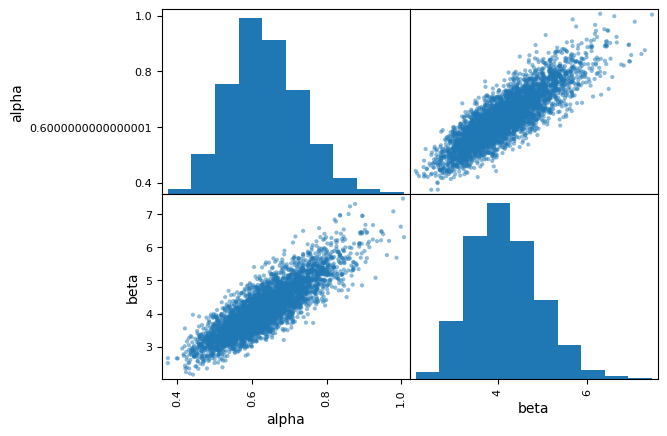

In [8]:
alpha_samps = fit.stan_variable('alpha')
beta_samps = fit.stan_variable('beta')
pd.plotting.scatter_matrix(pd.DataFrame({"alpha": alpha_samps, "beta": beta_samps}))

Alpha and beta a very correlated. This makes sense because the mean of a beta distribution is alpha over alpha plus beta. So when alpha increases, beta has to also increase to keep the mean the same.

## 1.6

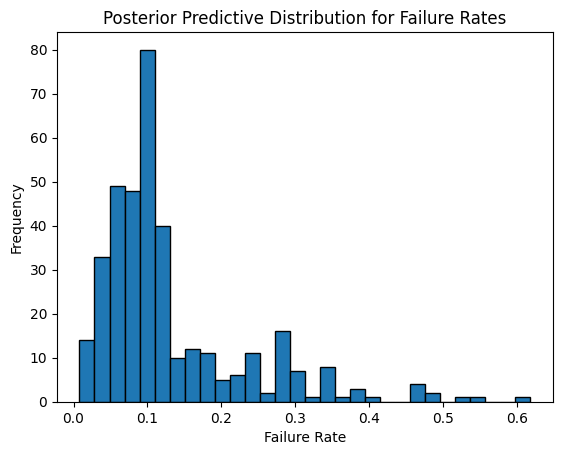

In [12]:
samples_df = fit.draws_pd()
y_pred_samples = samples_df.filter(like="y_pred_rate")
y_pred_mean = y_pred_samples.mean()

plt.hist(y_pred_mean, bins=30, edgecolor="black")
plt.title("Posterior Predictive Distribution for Failure Rates")
plt.ylabel("Frequency")
plt.xlabel("Failure Rate")
plt.show()

In [10]:
count = len([value for value in y_pred_mean if value > 0.01])
prob = count / len(rockets)
print(count)
print(prob)

365
0.9945504087193461


In this simulation, 365 of the 367 models had a probability of failure greater than 0.01. Since greater than 99% of the simulations have a probability of failure greater than 0.01 the chances are high that this new rocket will also have a probability of failure greater than 0.01.

## 1.7

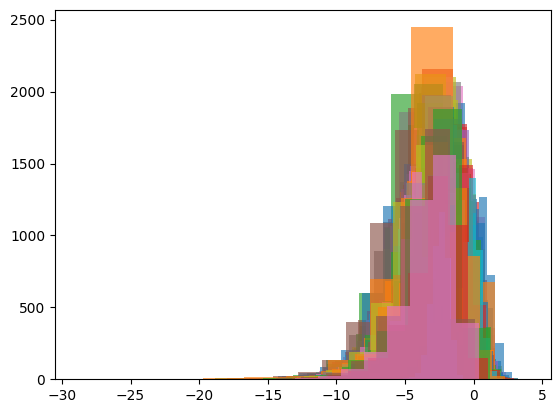

In [11]:
from scipy.special import logit
zs = fit.stan_variable("z")
for _ in range(len(rockets)):
    plt.hist(logit(zs)[:,_], alpha = .65)

## 1.8
$z$ is not our primary goal in this case because we are after the probability of a new rocket failing, not the individual failure distribution of each rocket we already know about.

## 1.9
If we had another model of the same rocket on our list and we wanted it's failure probability, then we should use inference on $z$.

## 1.10
This model assumes that all these rockets are exchangeable. In reality, while the rockets are similar, each rocket is very different (from design, to manufacturer, to tech advancements).

## 1.11
A frequentist would do one of two things. They could give a separate distribution for each rocket (holy moly that's a lot of distributions). Or, given the length of the dataset and and the lack of data in it, they would probably just combine all the data into a single distribution and use that to predict the probability of failure of this new rocket.